# Vanilla GAN(Generative Adversarial Network)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

> ## Import Packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Model,Sequential
from keras.layers import Dense, Dropout, Input, LeakyReLU

# I. Load MNIST Dataset

* Normalization and Reshape

In [ ]:
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Normalization: -1 ~ 1 Range
X_train = (X_train.astype(float) - 127.5) / 127.5  # (0-127.5) / / 127.5 = -1 , (255-127.5) / 127.5 = 1

# Reshape
X_train = X_train.reshape(60000, 28 * 28)

In [ ]:
X_train.shape

(60000, 784)

In [ ]:
y_train[:5]

array([5, 0, 4, 1, 9], dtype=uint8)

# II. 'generator' Model

* 랜덤 벡터(잠재공간의 랜덤 포인트)를 입력받아 이미지 생성
 - NOISE_DIM : 입력 랜덤 벡터 크기
* 'discriminator'를 속이도록 학습
 - 'Real Image'와 같은 'Fake Image' 생성이 목적

In [ ]:
NOISE_DIM = 10

generator = Sequential(name = 'generator')

generator.add(Dense(256, input_shape = (NOISE_DIM,)))
generator.add(LeakyReLU())
generator.add(Dense(512))
generator.add(LeakyReLU())
generator.add(Dense(1024))
generator.add(LeakyReLU())
generator.add(Dense(784, activation = 'tanh'))

* Model Summary

In [ ]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2816      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 784)               80

# III. 'discriminator' Model

* 이미지를 입력받아 'Real Image'인지 'generator'가 생성한 'Fake Image' 인지 판별
 - 이진분류

In [ ]:
from tensorflow.keras.initializers import RandomNormal # 파라미터값 초기화

discriminator = Sequential(name = 'discriminator')

discriminator.add(Dense(1024,
                        input_shape = (784,),
                        kernel_initializer = RandomNormal(stddev = 0.02)))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.5))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.5))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.5))
discriminator.add(Dense(1, activation = 'sigmoid'))

* Model Summary

In [ ]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              803840    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)             

> ## 1) 'discriminator' Compile

* 학습 설정
 - beta_1: Learning Rate 감쇠율 조정

In [ ]:
from tensorflow.keras.optimizers import Adam

discriminator.compile(loss = 'binary_crossentropy',
                      optimizer = Adam(lr = 0.0002,
                                       beta_1 = 0.5))

# IV. 'gan' Model

> ## 1) 'generator', 'discriminator' 연결

* 'gan' 모델에서 'generator'만 학습하도록 설정
 - discriminator.trainable = False

In [ ]:
discriminator.trainable = False

gan_input = Input(shape = (NOISE_DIM,))
x = generator(gan_input)
output = discriminator(x)

> ## 2) 'gan' Model

In [ ]:
gan = Model(gan_input, output, name = 'gan')

> ## 3) 'gan' Summary

In [ ]:
gan.summary()

Model: "gan"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 generator (Sequential)      (None, 784)               1463312   
                                                                 
 discriminator (Sequential)  (None, 1)                 1460225   
                                                                 
Total params: 2,923,537
Trainable params: 1,463,312
Non-trainable params: 1,460,225
_________________________________________________________________


> ## 4) 'gan' Compile

* 학습 설정

In [ ]:
gan.compile(loss = 'binary_crossentropy',
            optimizer = Adam(lr = 0.0002,
                             beta_1 = 0.5))

# V. Define 'get_batches( )' Function

* MNIST image batch 생성

In [ ]:
#  model fit이 없으므로, 학습용 batch 함수를 만들어준다.
def get_batches(data, batch_size):
    batches = []

    for i in range(data.shape[0] // batch_size):
        batch = data[i * batch_size : (i + 1) * batch_size]
        batches.append(batch)
    return np.asarray(batches)

# VI. 'visualize_training( )' Function

In [ ]:
def visualize_training(epoch, d_losses, g_losses):

    # 오차 시각화
    plt.figure(figsize=(8, 4))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generatror Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    print('epoch: {}, Discriminator Loss: {}, Generator Loss: {}'.format(epoch, np.asarray(d_losses).mean(), np.asarray(g_losses).mean()))

    # 이미지 생성 결과 시각화
    print('epoch :', epoch)
    noise = np.random.normal(0, 1, size = (24, NOISE_DIM)) # 평균 0 표준편차 1 , 24개 길이의 10
    generated_images = generator.predict(noise) # 노이즈로 784개의 fake img 생성
    generated_images = generated_images.reshape(-1, 28, 28)

    plt.figure(figsize = (8, 4))
    for i in range(generated_images.shape[0]):
        plt.subplot(4, 6, i + 1)
        plt.imshow(generated_images[i], interpolation = 'nearest', cmap = 'Greys_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# VII. Model Training

* 약 55분
<br>
<br>
* .fit( )
 - 'epoch', 'batch_size' 지정
* .train_on_batch( )
 - 전달 받은 모든 데이터를 사용하여 학습 진행
* 'generator'가 매번 새로운 'Fake Image'를 생성하여 '.train_on_batch( )' 사용

epoch : 1
1/1 [==============================] - 0s 52ms/step


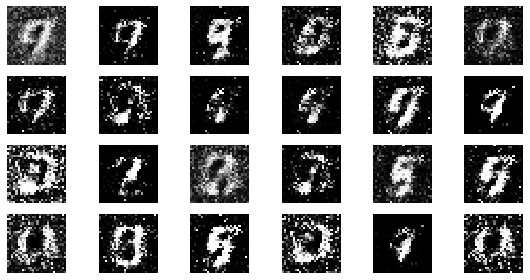

epoch : 5
1/1 [==============================] - 0s 14ms/step


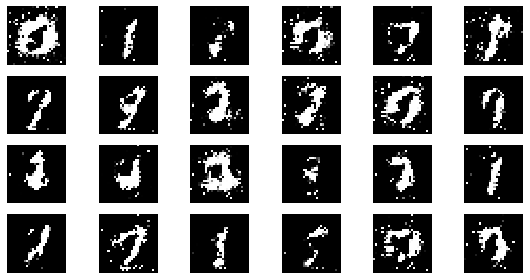

epoch : 10
1/1 [==============================] - 0s 15ms/step


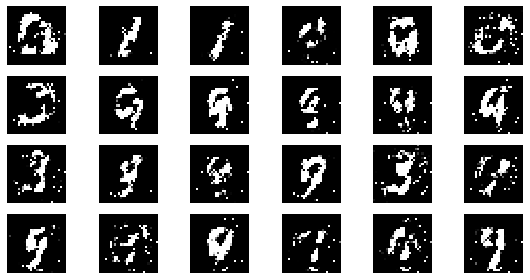

epoch : 15
1/1 [==============================] - 0s 16ms/step


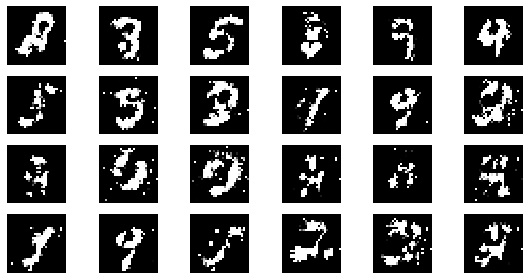

epoch : 20
1/1 [==============================] - 0s 15ms/step


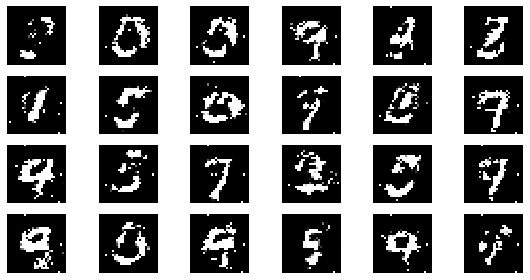

epoch : 25
1/1 [==============================] - 0s 21ms/step


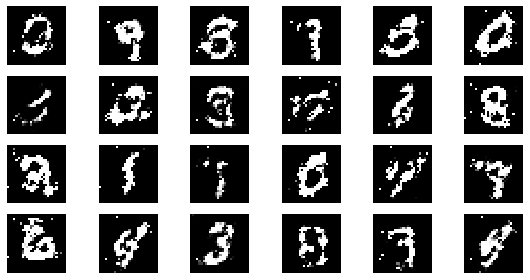

epoch : 30
1/1 [==============================] - 0s 14ms/step


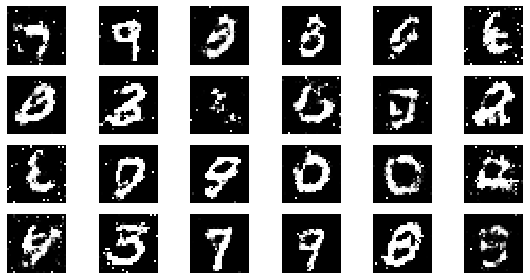

epoch : 35
1/1 [==============================] - 0s 15ms/step


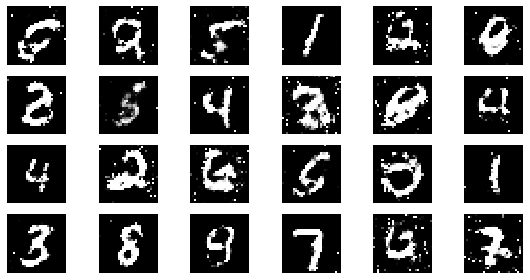

epoch : 40
1/1 [==============================] - 0s 19ms/step


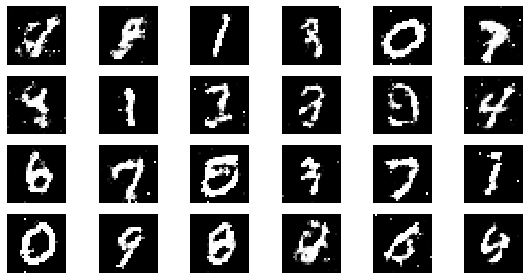

epoch : 45
1/1 [==============================] - 0s 15ms/step


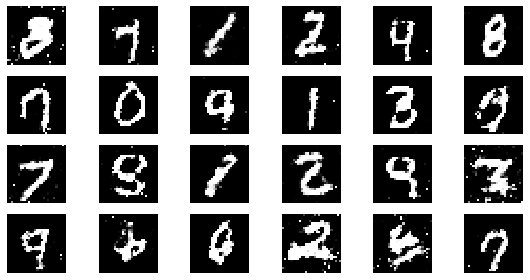

epoch : 50
1/1 [==============================] - 0s 21ms/step


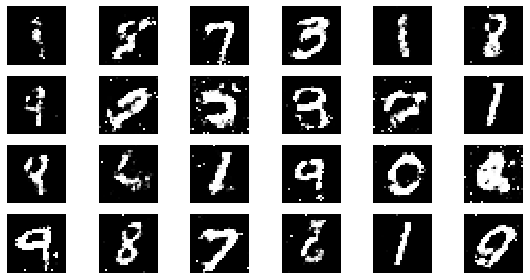

epoch : 55
1/1 [==============================] - 0s 15ms/step


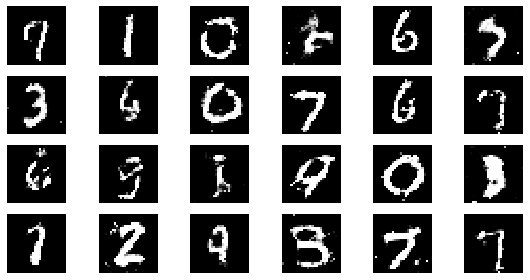

epoch : 60
1/1 [==============================] - 0s 19ms/step


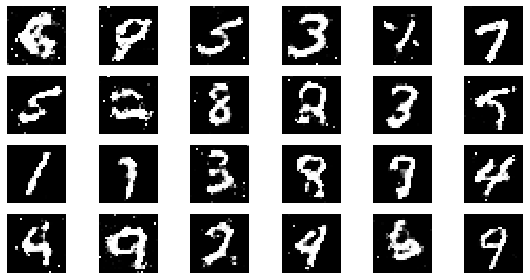

epoch : 65
1/1 [==============================] - 0s 18ms/step


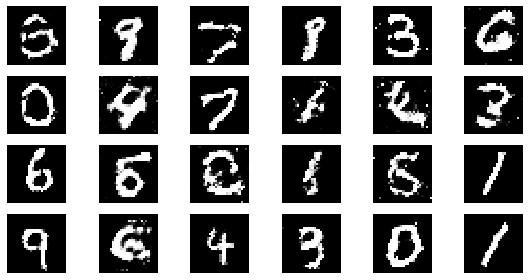

epoch : 70
1/1 [==============================] - 0s 15ms/step


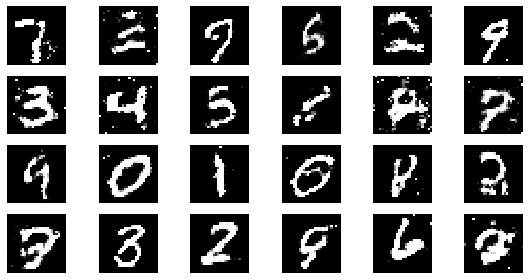

epoch : 75
1/1 [==============================] - 0s 16ms/step


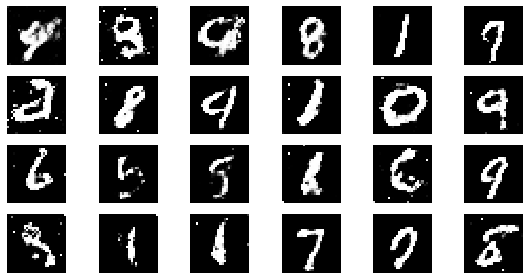

epoch : 80
1/1 [==============================] - 0s 18ms/step


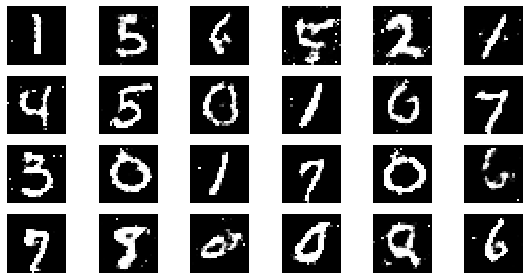

epoch : 85
1/1 [==============================] - 0s 15ms/step


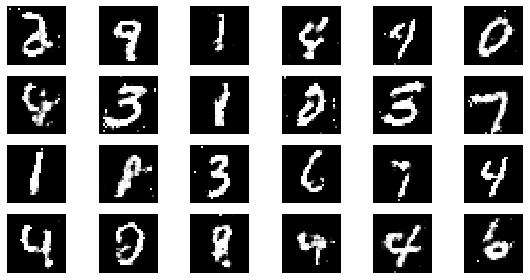

epoch : 90
1/1 [==============================] - 0s 15ms/step


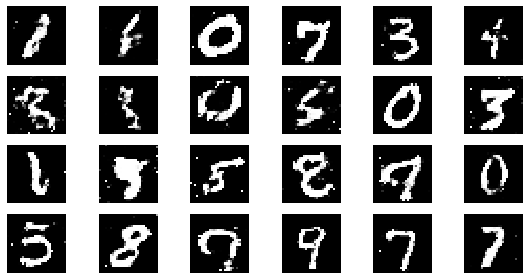

epoch : 95
1/1 [==============================] - 0s 16ms/step


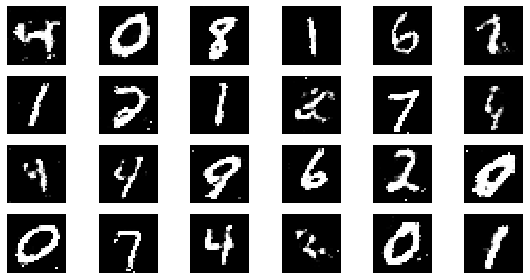

epoch : 100
1/1 [==============================] - 0s 16ms/step


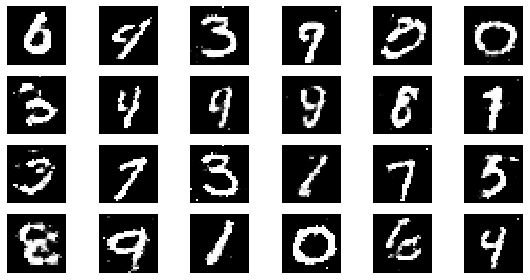

CPU times: user 47min 8s, sys: 2min 26s, total: 49min 35s
Wall time: 50min 18s


In [ ]:
# %%time

EPOCHS = 100
BATCH_SIZE = 128

# 'discriminator', 'gan' Loss 저장 List
d_losses = []
g_losses = []

for epoch in range(1, EPOCHS + 1):
    # batch 별 학습
    for real_images in get_batches(X_train, BATCH_SIZE):
        # Random Noise 생성
        input_noise = np.random.uniform(-1, 1, size = [BATCH_SIZE, NOISE_DIM])

        # Fake Image 데이터 생성
        generated_images = generator.predict(input_noise, verbose = 0)

        # 'discriminator' 학습용 X 데이터 정의
        x_dis = np.concatenate([real_images, generated_images]) # real img , fake img, row방향으로 병합

        # 'discriminator' 학습용 y 데이터 정의
        y_dis = np.zeros(2 * BATCH_SIZE)
        y_dis[:BATCH_SIZE] = 1 # real img만 1로 라벨링

        # 'discriminator' 학습
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(x_dis, y_dis) # fit

        # 'discriminator' 학습 정지
        discriminator.trainable = False

        # 'generator' 학습용 X,y 데이터 생성
        noise = np.random.uniform(-1, 1, size = [BATCH_SIZE, NOISE_DIM])
        y_gan = np.ones(BATCH_SIZE) # fake img를 real이라고 속임
        # 판별기를 속이기 위한 학습 loss를 측정하기 위해서

        # 'gan(generator)' 학습
        g_loss = gan.train_on_batch(noise, y_gan)

    d_losses.append(d_loss)
    g_losses.append(g_loss)

    # 생성 결과 시각화
    if epoch == 1 or epoch % 5 == 0:
        visualize_training(epoch, d_losses, g_losses)

# The End